In [79]:
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
#import timeit
import xgboost as xgb

from pandas.plotting import scatter_matrix
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

sns.set()
%matplotlib inline

In [2]:
# Reading the dataset into a data frame

sales_df = pd.read_csv("Advertisement.csv")
sales_df.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


Data Preprocessing

In [3]:
sales_df.drop(['Unnamed: 0'], axis = 1, inplace = True)
sales_df.head(2)

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4


In [4]:
# Checking for missing values

sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [5]:
sales_df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [6]:
sales_df.isnull().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

In [7]:
# Checking for duplicate values

sales_df.duplicated().sum()

0

In [8]:
# Train test split

train_df, validation_df = train_test_split(sales_df, train_size = 0.75, random_state = 1)
train_df.head(2)

,TV,Radio,Newspaper,Sales
98,289.7,42.3,51.2,25.4
123,123.1,34.6,12.4,15.2


In [9]:
validation_df.head(2)

,TV,Radio,Newspaper,Sales
58,210.8,49.6,37.7,23.8
40,202.5,22.3,31.6,16.6


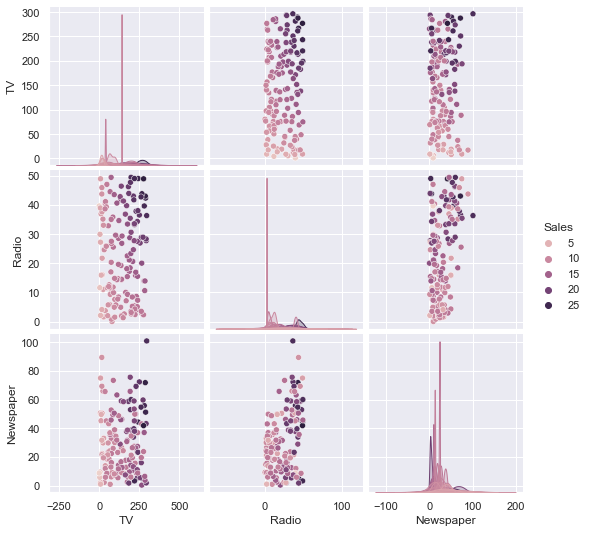

In [10]:
# Checking for the distribution of each variable
# Checking the pairplot

sns.pairplot(train_df, hue = "Sales")
plt.show()

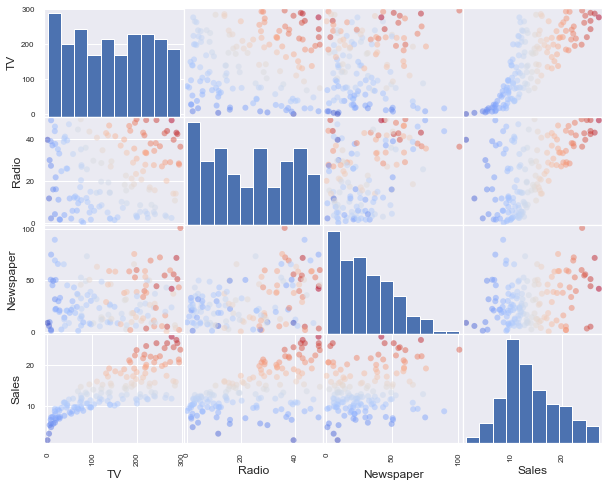

In [11]:
# Using scater-matrix plot

scatter_matrix(train_df, diagonal = "hist", marker = "o", c = train_df['Sales'], cmap = 'coolwarm', figsize = (10,8))
plt.show()

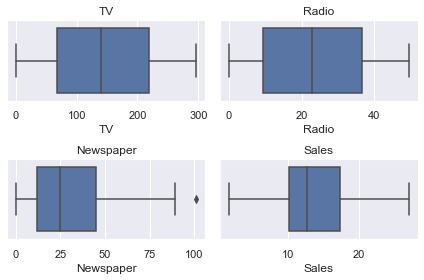

In [12]:
# Using box plot to see the distribution of each feature

plt.figure()

for col in train_df.select_dtypes(include = ['number']).columns:
    plt.subplot(2, 2, train_df.columns.get_loc(col) + 1)  # Adjust the subplot layout as needed
    sns.boxplot(x=train_df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

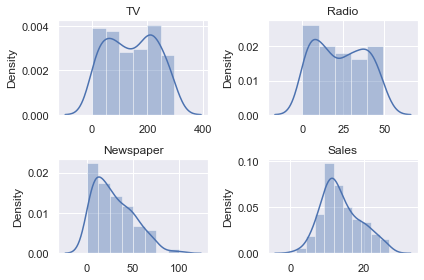

In [14]:
# Using distplot to see the distribution of each feature

plt.figure()

for col in train_df.select_dtypes(include = ['number']).columns:
    plt.subplot(2, 2, train_df.columns.get_loc(col) + 1)  # Adjust the subplot layout as needed
    sns.distplot(x=train_df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

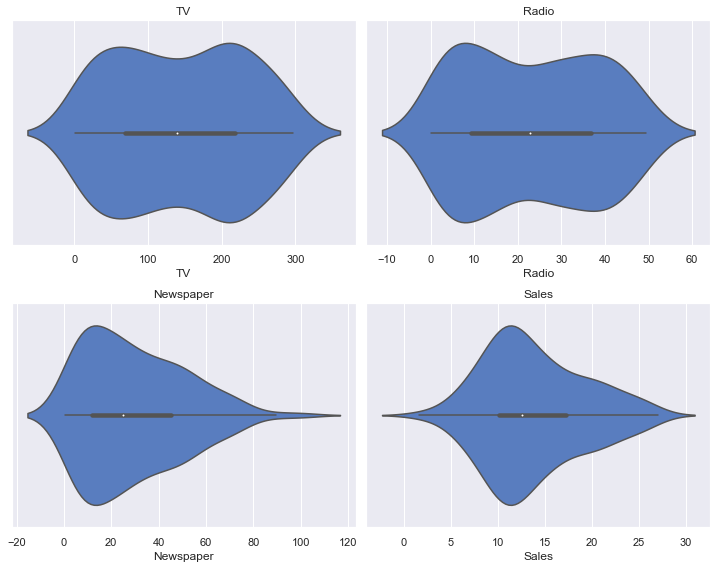

In [15]:
# Using violin plots to see a deper look into the distribution

plt.figure(figsize=(10, 8))

for col in train_df.select_dtypes(include = ['number']).columns:
    plt.subplot(2, 2, train_df.columns.get_loc(col) + 1)  # Adjust the subplot layout as needed
    sns.violinplot(x=train_df[col], palette = 'muted')
    plt.title(col)

plt.tight_layout()
plt.show()

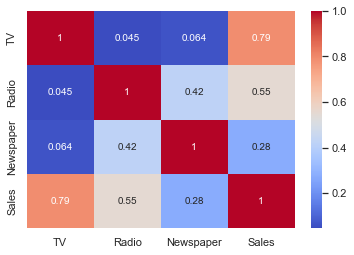

In [16]:
# Using heatmap to see the relationships

sns.heatmap(train_df.corr(), annot = True, cmap = "coolwarm")
plt.show()

In [22]:
# Checking each variable against the target variable

def sales_per(col, color):
    avg_sales = train_df.groupby(col)['Sales'].mean().reset_index()
    plt.figure(figsize = (10, 6))
    plt.bar(avg_sales[col], avg_sales['Sales'], color = color)
    plt.title('Sales based on {} ads'.format(col))
    plt.xlabel(col)
    plt.ylabel('Sales')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

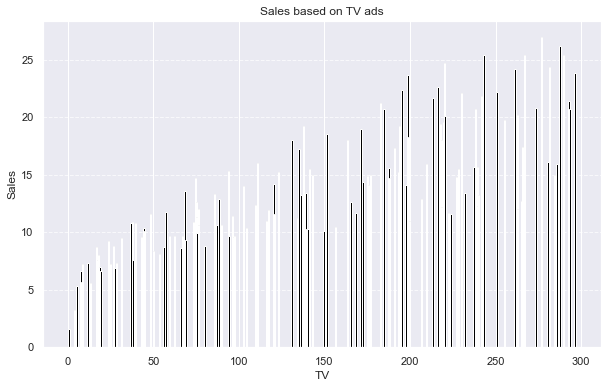

In [23]:
sales_per("TV","black")

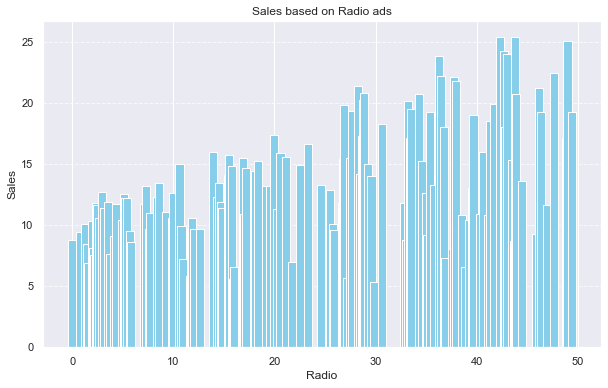

In [24]:
sales_per("Radio","skyblue")

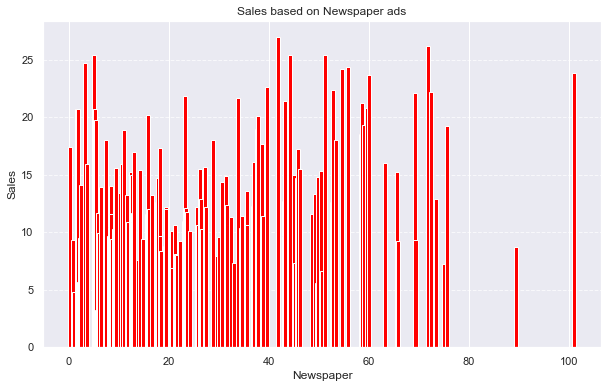

In [25]:
sales_per("Newspaper","red")

In [26]:
# Getting the ad details of top 10 selling products

top_10_products = train_df.nlargest(10, 'Sales')
top_10_products

,TV,Radio,Newspaper,Sales
175,276.9,48.9,41.8,27.0
183,287.6,43.0,71.8,26.2
98,289.7,42.3,51.2,25.4
36,266.9,43.8,5.0,25.4
147,243.2,49.0,44.3,25.4
128,220.3,49.0,3.2,24.7
17,281.4,39.6,55.8,24.4
61,261.3,42.7,54.7,24.2
101,296.4,36.3,100.9,23.8
55,198.9,49.4,60.0,23.7


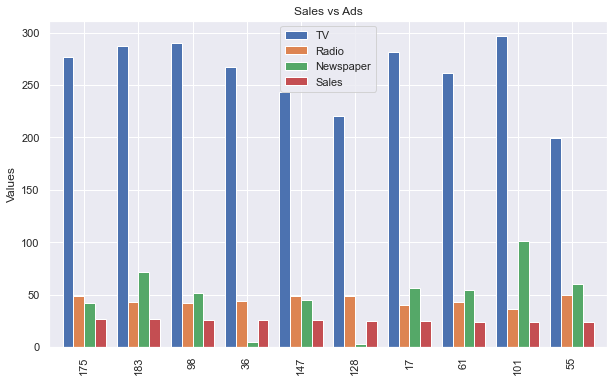

In [27]:
ax = top_10_products.plot(kind='bar', figsize=(10, 6), width=0.8)
ax.set_ylabel('Values')
plt.title('Sales vs Ads')

plt.show()

In [28]:
# Getting the sales details of products with more ads

train_df['Total_Ad_Spent'] = train_df['TV'] + train_df['Radio'] + train_df['Newspaper']
train_df.head(2)

,TV,Radio,Newspaper,Sales,Total_Ad_Spent
98,289.7,42.3,51.2,25.4,383.2
123,123.1,34.6,12.4,15.2,170.1


In [29]:
top_10_ads = train_df.nlargest(10, 'Total_Ad_Spent')
top_10_ads

,TV,Radio,Newspaper,Sales,Total_Ad_Spent
101,296.4,36.3,100.9,23.8,433.6
183,287.6,43.0,71.8,26.2,402.4
98,289.7,42.3,51.2,25.4,383.2
17,281.4,39.6,55.8,24.4,376.8
175,276.9,48.9,41.8,27.0,367.6
30,292.9,28.3,43.2,21.4,364.4
137,273.7,28.9,59.7,20.8,362.3
93,250.9,36.5,72.3,22.2,359.7
61,261.3,42.7,54.7,24.2,358.7
0,230.1,37.8,69.2,22.1,337.1


In [30]:
top_10_ads.drop(['Total_Ad_Spent'], axis = 1, inplace = True)
train_df.drop(['Total_Ad_Spent'], axis = 1, inplace = True)

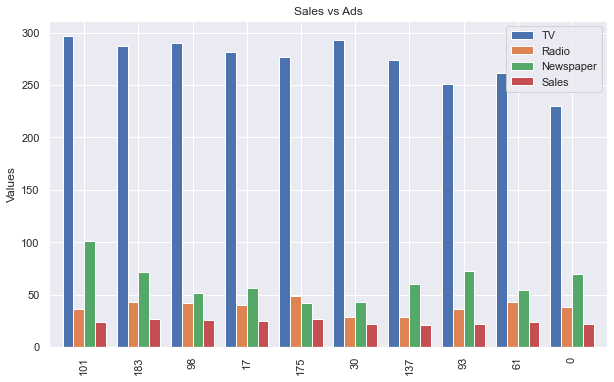

In [31]:
ax = top_10_ads.plot(kind='bar', figsize=(10, 6), width=0.8)
ax.set_ylabel('Values')
plt.title('Sales vs Ads')

plt.show()

Deductions from the visuals

In [32]:
# Splitting dependent and independent variable

raw_x_train = train_df.drop(['Sales'], axis = 1)
raw_y_train = train_df['Sales']

raw_x_val = validation_df.drop(['Sales'], axis = 1)
raw_y_val = validation_df['Sales']

raw_x_train.head(2)

,TV,Radio,Newspaper
98,289.7,42.3,51.2
123,123.1,34.6,12.4


In [33]:
raw_x_val.head(2)

,TV,Radio,Newspaper
58,210.8,49.6,37.7
40,202.5,22.3,31.6


In [34]:
# Building the models

# Linear Regression model
linear_model_raw = LinearRegression()
linear_model_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_lr = linear_model_raw.predict(raw_x_train)
raw_y_pred_val_lr = linear_model_raw.predict(raw_x_val)

In [35]:
print("Accuracy Scores for Linear Regression model on raw data")
raw_lr_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_lr)
raw_train_lr_r2s = r2_score(raw_y_train, raw_y_pred_train_lr)
raw_val_lr_r2s = r2_score(raw_y_val, raw_y_pred_val_lr)
print("Mean Squared Error :", raw_lr_rmse)
print("R-squared Score (Train) :", raw_train_lr_r2s)
print("R-squared Score (Test) :", raw_val_lr_r2s)
print("**************" * 7)

Accuracy Scores for Linear Regression model on raw data
Mean Squared Error : 1.9730456202283368
R-squared Score (Train) : 0.890307557755665
R-squared Score (Test) : 0.9156213613792232
**************************************************************************************************


In [36]:
# Lasso Regression (L1 Regularization)
lasso_model_raw = Lasso()
lasso_model_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_lar = lasso_model_raw.predict(raw_x_train)
raw_y_pred_val_lar = lasso_model_raw.predict(raw_x_val)

In [37]:
print("Accuracy Scores for Lasso Regression (L1 Regularization) model on raw data")
raw_lar_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_lar)
raw_train_lar_r2s = r2_score(raw_y_train, raw_y_pred_train_lar)
raw_val_lar_r2s = r2_score(raw_y_val, raw_y_pred_val_lar)
print("Mean Squared Error :", raw_lar_rmse)
print("R-squared Score (Train) :", raw_train_lar_r2s)
print("R-squared Score (Test) :", raw_val_lar_r2s)
print("**************" * 7)

Accuracy Scores for Lasso Regression (L1 Regularization) model on raw data
Mean Squared Error : 2.0076670518175126
R-squared Score (Train) : 0.8901342886277591
R-squared Score (Test) : 0.9141407522971794
**************************************************************************************************


In [40]:
# Ridge Regression (L2 Regularization)
ridge_model_raw = Ridge()
ridge_model_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_ridge = ridge_model_raw.predict(raw_x_train)
raw_y_pred_val_ridge = ridge_model_raw.predict(raw_x_val)

In [41]:
print("Accuracy Scores for Ridge Regression (L2 Regularization) model on raw data")
raw_ridge_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_ridge)
raw_train_ridge_r2s = r2_score(raw_y_train, raw_y_pred_train_ridge)
raw_val_ridge_r2s = r2_score(raw_y_val, raw_y_pred_val_ridge)
print("Mean Squared Error :", raw_ridge_rmse)
print("R-squared Score (Train) :", raw_train_ridge_r2s)
print("R-squared Score (Test) :", raw_val_ridge_r2s)
print("**************" * 7)

Accuracy Scores for Ridge Regression (L2 Regularization) model on raw data
Mean Squared Error : 1.9731360610267676
R-squared Score (Train) : 0.890307557490011
R-squared Score (Test) : 0.9156174936169328
**************************************************************************************************


In [46]:
# Elastic Net Regression (L1 and L2 Regularizations)
enet_model_raw = ElasticNet()
enet_model_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_enet = enet_model_raw.predict(raw_x_train)
raw_y_pred_val_enet = enet_model_raw.predict(raw_x_val)

In [47]:
print("Accuracy Scores for Elastic Net Regression (L1 and L2 Regularizations) model on raw data")
raw_enet_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_enet)
raw_train_enet_r2s = r2_score(raw_y_train, raw_y_pred_train_enet)
raw_val_enet_r2s = r2_score(raw_y_val, raw_y_pred_val_enet)
print("Mean Squared Error :", raw_enet_rmse)
print("R-squared Score (Train) :", raw_train_enet_r2s)
print("R-squared Score (Test) :", raw_val_enet_r2s)
print("**************" * 7)

Accuracy Scores for Elastic Net Regression (L1 and L2 Regularizations) model on raw data
Mean Squared Error : 1.9963873026756207
R-squared Score (Train) : 0.8902510395505827
R-squared Score (Test) : 0.9146231384451826
**************************************************************************************************


In [48]:
# Decission Tree regression - Choosing max depth as 6 after trying different values
dtree_raw = DecisionTreeRegressor(max_depth = 6)
dtree_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_dtree = dtree_raw.predict(raw_x_train)
raw_y_pred_val_dtree = dtree_raw.predict(raw_x_val)

In [49]:
print("Accuracy Scores for Decision Tree model on raw data")
raw_dtree_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_dtree)
raw_train_dtree_r2s = r2_score(raw_y_train, raw_y_pred_train_dtree)
raw_val_dtree_r2s = r2_score(raw_y_val, raw_y_pred_val_dtree)
print("Mean Squared Error :", raw_dtree_rmse)
print("R-squared Score (Train) :", raw_train_dtree_r2s)
print("R-squared Score (Test) :", raw_val_dtree_r2s)
print("**************" * 7)

Accuracy Scores for Decision Tree model on raw data
Mean Squared Error : 1.1670832057823128
R-squared Score (Train) : 0.9948414172626995
R-squared Score (Test) : 0.9500888924962176
**************************************************************************************************


In [50]:
# Random Forest regression - Choosing max depth as 6 after trying different values
# Choosing the parameters after trying different values
rf_raw = RandomForestRegressor(n_estimators = 500, random_state = 1, max_depth = 6)
rf_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_rf = rf_raw.predict(raw_x_train)
raw_y_pred_val_rf = rf_raw.predict(raw_x_val)

In [51]:
print("Accuracy Scores for Random Forest model on raw data")
raw_rf_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_rf)
raw_train_rf_r2s = r2_score(raw_y_train, raw_y_pred_train_rf)
raw_val_rf_r2s = r2_score(raw_y_val, raw_y_pred_val_rf)
print("Mean Squared Error :", raw_rf_rmse)
print("R-squared Score (Train) :", raw_train_rf_r2s)
print("R-squared Score (Test) :", raw_val_rf_r2s)
print("**************" * 7)

Accuracy Scores for Random Forest model on raw data
Mean Squared Error : 0.40992725337108105
R-squared Score (Train) : 0.9954418189405353
R-squared Score (Test) : 0.9824691820511463
**************************************************************************************************


In [52]:
# Gradient Boosting Regression model
gb_raw = GradientBoostingRegressor(n_estimators = 100, max_depth = 3, random_state = 123)
gb_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_gb = gb_raw.predict(raw_x_train)
raw_y_pred_val_gb = gb_raw.predict(raw_x_val)

In [53]:
print("Accuracy Scores for Gradient Boost Regressor model on raw data")
raw_gb_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_gb)
raw_train_gb_r2s = r2_score(raw_y_train, raw_y_pred_train_gb)
raw_val_gb_r2s = r2_score(raw_y_val, raw_y_pred_val_gb)
print("Mean Squared Error :", raw_gb_rmse)
print("R-squared Score (Train) :", raw_train_gb_r2s)
print("R-squared Score (Test) :", raw_val_gb_r2s)
print("**************" * 7)

Accuracy Scores for Gradient Boost Regressor model on raw data
Mean Squared Error : 0.39330203215430165
R-squared Score (Train) : 0.9988744334979055
R-squared Score (Test) : 0.9831801709500643
**************************************************************************************************


In [54]:
# XGBoost Regression model - Max depth = 2 after testing various values
xgb_raw = xgb.XGBRegressor(random_state = 111, max_depth = 2)
xgb_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_xgb = xgb_raw.predict(raw_x_train)
raw_y_pred_val_xgb = xgb_raw.predict(raw_x_val)

In [55]:
print("Accuracy Scores for XGBoost model on raw data")
raw_xgb_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_xgb)
raw_train_xgb_r2s = r2_score(raw_y_train, raw_y_pred_train_xgb)
raw_val_xgb_r2s = r2_score(raw_y_val, raw_y_pred_val_xgb)
print("Mean Squared Error :", raw_xgb_rmse)
print("R-squared Score (Train) :", raw_train_xgb_r2s)
print("R-squared Score (Test) :", raw_val_xgb_r2s)
print("**************" * 7)

Accuracy Scores for XGBoost model on raw data
Mean Squared Error : 0.4221199878759987
R-squared Score (Train) : 0.9972178953877221
R-squared Score (Test) : 0.9819477514628001
**************************************************************************************************


In [56]:
# Support Vector Regression model - Linear kernel
svr_linear_raw = SVR(kernel = 'linear')
svr_linear_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_svr_linear = svr_linear_raw.predict(raw_x_train)
raw_y_pred_val_svr_linear = svr_linear_raw.predict(raw_x_val)

In [57]:
print("Accuracy Scores for Support Vector Model with linear kernel on raw data")
raw_svr_linear_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_svr_linear)
raw_train_svr_linear_r2s = r2_score(raw_y_train, raw_y_pred_train_svr_linear)
raw_val_svr_linear_r2s = r2_score(raw_y_val, raw_y_pred_val_svr_linear)
print("Root Mean Squared Error :", raw_svr_linear_rmse)
print("R-squared Score (Train) :", raw_train_svr_linear_r2s)
print("R-squared Score (Test) :", raw_val_svr_linear_r2s)
print("**************" * 7)

Accuracy Scores for Support Vector Model with linear kernel on raw data
Root Mean Squared Error : 1.9220583190995177
R-squared Score (Train) : 0.881634835018431
R-squared Score (Test) : 0.9178018680092217
**************************************************************************************************


In [58]:
# Support Vector Regression model - Poly kernel
svr_poly_raw = SVR(kernel = 'poly')
svr_poly_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_svr_poly = svr_poly_raw.predict(raw_x_train)
raw_y_pred_val_svr_poly = svr_poly_raw.predict(raw_x_val)

In [59]:
print("Accuracy Scores for Support Vector Model with poly kernel on raw data")
raw_svr_poly_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_svr_poly)
raw_train_svr_poly_r2s = r2_score(raw_y_train, raw_y_pred_train_svr_poly)
raw_val_svr_poly_r2s = r2_score(raw_y_val, raw_y_pred_val_svr_poly)
print("Root Mean Squared Error :", raw_svr_poly_rmse)
print("R-squared Score (Train) :", raw_train_svr_poly_r2s)
print("R-squared Score (Test) :", raw_val_svr_poly_r2s)
print("**************" * 7)

Accuracy Scores for Support Vector Model with poly kernel on raw data
Root Mean Squared Error : 3.087389548470164
R-squared Score (Train) : 0.8462785174762764
R-squared Score (Test) : 0.8679656849689169
**************************************************************************************************


In [60]:
# Support Vector Regression model - RBF kernel
svr_rbf_raw = SVR(kernel = 'rbf')
svr_rbf_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_svr_rbf = svr_rbf_raw.predict(raw_x_train)
raw_y_pred_val_svr_rbf = svr_rbf_raw.predict(raw_x_val)

In [61]:
print("Accuracy Scores for Support Vector Model with rbf kernel on raw data")
raw_svr_rbf_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_svr_rbf)
raw_train_svr_rbf_r2s = r2_score(raw_y_train, raw_y_pred_train_svr_rbf)
raw_val_svr_rbf_r2s = r2_score(raw_y_val, raw_y_pred_val_svr_rbf)
print("Root Mean Squared Error :", raw_svr_rbf_rmse)
print("R-squared Score (Train) :", raw_train_svr_rbf_r2s)
print("R-squared Score (Test) :", raw_val_svr_rbf_r2s)
print("**************" * 7)

Accuracy Scores for Support Vector Model with rbf kernel on raw data
Root Mean Squared Error : 3.8480442325973847
R-squared Score (Train) : 0.8541218680671167
R-squared Score (Test) : 0.8354357697712419
**************************************************************************************************


In [62]:
# Function to find the best value of K based on mean squared error

def find_k(x_train, y_train, x_test, y_test):
    error_rate = []    # Finding the error rate for 50 iterations

    for i in range(1, 50):
        knn = KNeighborsRegressor(n_neighbors = i)    # Building the model with i neighbors
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_test)
        error_rate.append(mean_squared_error(y_test, y_pred))
    
# Ploting the error values to find the best value of k
    
    plt.figure(figsize = (8, 8))
    plt.plot(range(1,50), error_rate, color = 'red', linestyle = 'dashed', marker = 'o', markersize = 10, markerfacecolor = 'blue')
    plt.title("Mean Squared Error vs K-Value")
    plt.xlabel("K-Value")
    plt.ylabel("Mean Squared Error")
    plt.show()

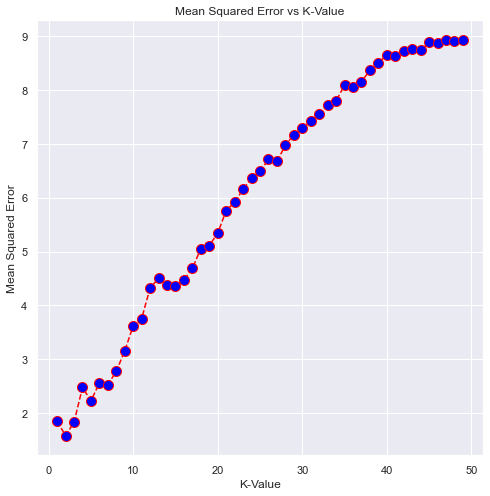

In [63]:
find_k(raw_x_train, raw_y_train, raw_x_val, raw_y_val)

The error value is least in k = 2, proceeding with k = 2

In [71]:
# Building KNN regressor with k = 2
knn_raw = KNeighborsRegressor(n_neighbors = 2)
knn_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_knn = knn_raw.predict(raw_x_train)
raw_y_pred_val_knn = knn_raw.predict(raw_x_val)

print("Accuracy Scores for KNN Regressor model on raw data")
raw_knn_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_knn)
raw_train_knn_r2s = r2_score(raw_y_train, raw_y_pred_train_knn)
raw_val_knn_r2s = r2_score(raw_y_val, raw_y_pred_val_knn)
print("Mean Squared Error :", raw_knn_rmse)
print("R-squared Score (Train) :", raw_train_knn_r2s)
print("R-squared Score (Test) :", raw_val_knn_r2s)
print("**************" * 7)

Accuracy Scores for KNN Regressor model on raw data
Mean Squared Error : 1.5839000000000005
R-squared Score (Train) : 0.9758064493202534
R-squared Score (Test) : 0.9322634386446769
**************************************************************************************************


Considering the results, the Random Forest model appears to be the best among the three.

In [72]:
# Saving model for deployment

final_model = rf_raw
filename = '04_Sales_Predictions.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [73]:
out_df = sales_df

In [74]:
# Splitting dependent and independent variable

x_final = out_df.drop(['Sales'], axis = 1)
y_final = out_df['Sales']

In [75]:
# Predicting the Rating using Random Forest model that was chosen as final model

y_pred = final_model.predict(x_final)

In [76]:
final_result = pd.DataFrame(y_pred)
final_result = final_result.rename(columns = {0 : "Predicted_Sales"})
final_result

,Predicted_Sales
0,21.772631
1,10.772412
2,8.735757
3,18.249825
4,13.835012
...,...
195,7.955268
196,9.821359
197,12.842530
198,24.842458


In [77]:
# Preparing the final data fram for output

final_result1 = pd.concat([sales_df, pd.DataFrame(final_result)], axis = 1)
final_result1.head(5)

,TV,Radio,Newspaper,Sales,Predicted_Sales
0,230.1,37.8,69.2,22.1,21.772631
1,44.5,39.3,45.1,10.4,10.772412
2,17.2,45.9,69.3,9.3,8.735757
3,151.5,41.3,58.5,18.5,18.249825
4,180.8,10.8,58.4,12.9,13.835012


In [78]:
final_result1.to_csv("04_Predicted_Sales.csv")